In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt
import numpy.testing as npt
import numpy as np
import matplotlib.pyplot as plt
import logging
import importlib
import scipy as sp
import warnings
import seaborn as sns   
#import psutil
#import statsmodels 
from pandas import DataFrame
from numpy import vstack, add, float64, multiply, exp, zeros, nan_to_num, vstack, where, power
from numpy import add, float64, multiply, exp, zeros, nan_to_num, vstack, where, power
from scipy.stats import rv_continuous
import scipy.stats
from scipy.stats import gamma, beta
from numpy import add, float64, multiply, exp, zeros, nan_to_num, vstack, where, power
from pandas import DataFrame
from numpy import sin, arange, isclose
from scipy.optimize import differential_evolution, Bounds, shgo, dual_annealing, minimize
from scipy import signal
from importlib import reload
from matplotlib.patches import Patch
from scipy.stats import pearsonr
from scipy.stats import spearmanr
warnings.filterwarnings("ignore")

from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os
from mpl_toolkits import mplot3d
from matplotlib import cm, colors
#from statsmodels.graphics.tsaplots import plot_acf
#Set the directory
os.chdir("/home/htuerk/Desktop/Tracer_Transport_Model/Model_Run")
saveDir = '/home/htuerk/Desktop/Tracer_Transport_Model/Output/Plots'

os.chdir("/home/htuerk/Documents/BOKU_22_AUG_2023/REPEATphd/HydroPy/")
#from BasicModel.Hydmod import xMod_Flex
import tracer_models as tracer_models
from tracer_models import ObjectiveFunction
from tracer_models import Tracer_Mod_Wetness # Model which SAS parameter is function of Soil Wetness
from tracer_models import Tracer_Mod_Ptresh_Wetness # Model which SAS parameter is function of Soil Wetness and Precipitation Threshold

In [ ]:

## Test optimization 
#Read Hyrological Data 
meas_df =  pd.read_csv("DATA/read_your_data", parse_dates=['Date'],index_col='Date',).squeeze("columns")
#interpolTE NAN values meas_df PET


wp =365    ## warm up period
nt = meas_df.Qmmd.size ## calibration period end index


## lets prepare the data to numpy as input format to run the model
evap =meas_df.PET[0:nt].to_numpy()
#apend zero to evap < 0
evap = np.where(evap < 0, 0, evap)
prec = meas_df.Pmmd[0:nt].to_numpy()
temp = meas_df.T_mean[0:nt].to_numpy()
flow = meas_df.Qmmd[0:nt].to_numpy()

##Deuterium data P is precipitation and Q is flow
ConP_O= meas_df.P_O[0:nt ].to_numpy()
ConQ_O= meas_df.Q_O[0:nt ].to_numpy()
Con_O_week = meas_df.Oxygen[0:2000].to_numpy() 

#nan values in ConP and ConQ to zero
ConP = np.nan_to_num(ConP_O)
ConQ = np.nan_to_num(ConQ_O)
Conweek = np.nan_to_num(Con_O_week)
#ConQ zero values to nan
ConQ = np.where(ConQ == 0, np.nan, ConQ)
Conweek = np.where(Conweek == 0, np.nan, Conweek)


#Lets  calculate 3 month moving average for the flow data to get Runoff Coefficient

df = pd.DataFrame({"flow":meas_df.Qmmd[wp:nt] , "prec": meas_df.Pmmd[wp:nt]})
#df_n = Rolled_df.iloc[::90, :]
df_n  = df.groupby(np.arange(len(df))//90).mean()
df_n['QperP'] = df_n.flow/df_n.prec

##  Prepare the inital storage Tracer composition for  unsaturated zone Su and Passive Groundwater Ssp
valid_indices_O = ~np.isnan(ConQ_O)
filtered_Qo_O = flow[valid_indices_O]
filtered_ConcQ_O = ConQ_O[valid_indices_O]
percentile_5_O = np.percentile(filtered_Qo_O, 5)
filtered_ConcQ_O = filtered_ConcQ_O[filtered_Qo_O <= percentile_5_O]
ConcSsp_avg_O = np.nanmean(filtered_ConcQ_O)
ConcSu_avg = np.nansum(ConP_O*prec) / np.nansum(prec)

In [ ]:
# Calibrate the model
#Set the case as "Cal"
#If the Case is "Cal" the model will retuns 
#Flux matrix of Fluxes as
# Flux_df = pd.DataFrame({'Flux_RM': Flux_RM, 'Flux_Pe': Flux_Pe, 'Flux_Ei': Flux_Ei, 'Flux_rf': Flux_rf, 'Flux_ea': Flux_ea, 'Flux_rs': Flux_rs, 'Flux_rfs': Flux_rfs, 'Flux_rfn': Flux_rfn, 'Flux_Qo': Flux_Qo, 'Flux_Qf': Flux_Qf, 
# 'Flux_Qof': Flux_Qof, 'Flux_Qstot': Flux_Qstot, 'Flux_Ql': Flux_Ql})
#Age matix of Fluxes as 
# Age_MR = [RM_Age_MR, Pe_Age_MR, rf_Age_MR, rfs_Age_MR, rfn_Age_MR, Qf_Age_MR, Qof_Age_MR, Qstot_Age_MR, Ql_Age_MR, Qo_Age_MR, rs_Age_MR, Ei_Age_MR, ea_Age_MR]
#  
# ## df_WB ## will return the hydrological model water balance components   
# df_WB = ["Qtot", "Qs", "Ql", "Qf", "Qof", "Qo", "Ss", "Si", "Sr", "Ssa", "Ssp", "Sf", "Rs","Rsg", "Rmelt", "Rff", "Rfn", "Rfs", "Ei", "Ea", "Etot", "Pe",
#                   "Ps", "M", "Cr","Cn", "alphat"]
############################## ----Define the Model Parameter----#################################
parameters = pd.DataFrame(columns=["initial", "pmin", "pmax"])
parameters.loc["srmax"] = (300.0, 100, 500)           #0 SU capacity 
parameters.loc["lp"] =    (0.26, 1e-5, 1)             #1 Ea calculation parameter
parameters.loc["Rsmax"] =  (1.05, 0.0, 1.2)          #2 Saturated hydraulic conductivity
parameters.loc["beta"] = (0.17, 1e-5, 5.0)           #3 Parameter determining the nonlinearity of outflow / recharge.
parameters.loc["Kp"] =  (1e-8, 1e-10, 1e-5)         #4 Loss coefficient
parameters.loc["Imax"] = (4.97, 1.2, 5.0)            #5 Interception capacity
parameters.loc["Ka"] = (0.18, 0.01, 0.2)             #6 slow responce coefficient
parameters.loc["tt"] = (-2.0, -4.0, 5.0)             #7 Melt treshold temperature
parameters.loc["fmelt"] =  (2.81, 1.0, 5.0)           #8 melt factor
parameters.loc["sfmax"] = (1.013, 1.0, 20.0)          #9 Fast responce capacity
parameters.loc["kf"] = (0.9, 0.01, 2.0)               #10 fast responce coefficient
parameters.loc["cp"] = (0.5, 0.1, 1.0)              #11 divider to fast responce slow responce (1-cp) =Rfs
parameters.loc["cn"] = (0.6, 0.1, 1.0)              #12 divider to fast responce to overland flow
parameters.loc["Bf"] = (1e-8, 1e-10,1e-5)            #13 overland flow coefficient
parameters.loc["SSp"] = (3000.0, 500.0, 10000.0)      #14  passive storage  coefficient
parameters.loc["Ptres"] = (6.0, 2.0, 20.0)            #15  SAS  tree water
parameters.loc["SU_Alpha"] = (0.1, 0.01, 1.0)         #16  SAS  SU_alpha
parameters.loc["SG_Alpha"] = (0.99, 0.98, 1.0)        #17 SAS SG_alpha  

par =parameters.initial.values

In [ ]:
## get fittenss
##  Change the Tracer_Mod_Wetness to Tracer_Mod_Ptresh_Wetness, to use the model with Precipitation Threshold
def fitness(par):
    par =par
    Flux_TB, Agn_MR , df_WB = Tracer_Mod_Wetness.Tracer_Mod().get_tracer_balance(prec, evap, temp, ConP_O, ConcSsp_avg_O, ConcSu_avg,  p = par,  Case ='Cal') #
    Flux_Qtot  = Flux_TB.Flux_Qstot+ Flux_TB.Flux_Qo + Flux_TB.Flux_Qof + Flux_TB.Flux_Qf # get total Q flux
    Qtot_Age  = Agn_MR[5] + Agn_MR[6] + Agn_MR[7]+ Agn_MR[9] # get Qtot _Age  = Qf_Age_MR, Qof_Age_MR, Qstot_Age_MR,
    Qtot = Qtot_Age.sum(axis=0) #Sum Qtot_Age columns to estimate total Q mmd-1
    Flux_Qtot = Flux_Qtot[:-1] # remove the last value as it is extra
    Conc_sim  = Flux_Qtot/Qtot[:-1] # calculate the concentration of the simulated tracer
    C_obs = ConQ_O[wp:nt] # observed tracer concentration
    C_sim  = Conc_sim[wp:nt].values # simulated tracer concentration for defined calibration period 
    C_week = Conweek[wp:nt] #Observed weekly tracer concentration 
    obs = flow[wp:nt] # observed flow for defined calibration period
    QP= df_n.QperP # observed runoff coefficient
    sim_Q = df_WB.Qtot[wp:nt].values # simulated flow for defined calibration period
    obs_Q = flow[wp:nt] # observed flow for defined calibration period
    Q_Avarage_sim  = pd.DataFrame({"flow":df_WB.Qtot[wp:nt] , "prec":prec[wp:nt]}) # Claculate the average flow and precipitation for the defined calibration period
    df_OP = Q_Avarage_sim.groupby(np.arange(len(Q_Avarage_sim))//90).mean() # 
    OP_sim = df_OP.flow/df_OP.prec # simulated runoff coefficient for the defined calibration period
    Ei =  ObjectiveFunction.nashsutcliffe(obs, sim_Q) # Nash-Sutcliffe efficiency for flow
    TB_nse = ObjectiveFunction.nashsutcliffe(C_obs,C_sim) # Nash-Sutcliffe efficiency for tracer balance
    TB_veek = ObjectiveFunction.mse(C_week, C_sim) # Mean Squared Error for weekly tracer concentration
    Eii = ObjectiveFunction.lognashsutcliffe(obs,sim_Q) # Log Nash-Sutcliffe efficiency for flow
    Eiii =  ObjectiveFunction.nse_FDC(obs,sim_Q) # Nash-Sutcliffe efficiency for flow duration curve
    Ebase = ObjectiveFunction.nashsutcliffe(QP,OP_sim) # Nash-Sutcliffe efficiency for runoff coefficient
    # Calculate the fitness value DE
    DE = np.sqrt(0.5*(((0.25*(1 -Ei)**2 + 0.25*(1-Ebase)**2 + 0.25*(1-Eii)**2 +0.25*(1-Eiii)**2)) + (0.5*(1-TB_nse)**2 + 0.5*(TB_veek)**2))) # Cost function
    return DE

bounds = Bounds(lb= parameters.pmin.values, ub=parameters.pmax.values, keep_feasible=False)

# Model to be optimized
# Initialize a list to hold solutions that meet the criterion
satisfactory_solutions = []

# Maximum number of solutions to keep
max_solutions = 1000  # Adjust as needed

def callback_efficient(xk, convergence):
    global satisfactory_solutions
    # Check if the solution meets the criterion
    current_fitness = fitness(xk)
    if current_fitness < 1:  # Criterion: fitness value should be less than 1
        satisfactory_solutions.append((xk, current_fitness))
        # Sort the list based on fitness (for minimizing)
        satisfactory_solutions.sort(key=lambda sol: sol[1])
        # Ensure the list does not exceed the maximum length
        satisfactory_solutions = satisfactory_solutions[:max_solutions]

# %%
# Run the differential evolution optimizer set the workers as nedeed
# Change the updating parameter to 'differ" to change the updating strategy
#fitness is your fittnes function valu of "DE" 
result = differential_evolution(fitness, bounds,  callback=callback_efficient, updating='immediate', workers=8, maxiter=500)

print("optimization done!!!!")

# Save Result .x as data frame 
df_result = pd.DataFrame({"par":result.x}) 
df_result.to_csv(".Set_Directory_to save")

In [ ]:
#Read_optimized parameter function of soil wetness to run the model 
Parameter_S1 = pd.read_csv(".read the optimized parameter model calibration S1 .csv")
parOpt_S1 = Parameter_S1.par.values

#Read_optimized parameter  Ptresh and wetness to run the model 
Parameter_S2 = pd.read_csv(".read the optimized parameter model calibration S1 .csv")
parOpt_S2 = Parameter_S2.par.values

################Run the model with calibrated parameters ################
# Set the case as "notCal" to retun the Storage age matrix and Flux matrix
# Storage_Age_MR =  [SS_Age_MR, Si_Age_MR, Sr_Age_MR, Sf_Age_MR, SSa_Age_MR]
# Storage_Flux_MR = [SS_Flux_MR, Si_Flux_MR, Sr_Flux_MR, Sf_Flux_MR, SSa_Flux_MR]

Agn_MR_SASt, Flux_dfn_SASt, Storage_Age_MR_SASt, Storage_Flux_MR_SASt, TrB_SASt, WB_test_SASt, = Tracer_Mod_Wetness.Tracer_Mod().get_tracer_balance(prec, evap, temp, ConP_O,  ConcSsp_avg_O, ConcSu_avg,  p = parOpt_S1, Case ='notCal')
Agn_MR, Flux_dfn, Storage_Age_MR, Storage_Flux_MR, TrB, WB_test =Tracer_Mod_Ptresh_Wetness.Tracer_Mod().get_tracer_balance(prec, evap, temp, ConP_O, ConcSsp_avg_O, ConcSu_avg,  p = parOpt_S2,  Case ='notCal')

# Check the result for water balance
def Get_WB_error(WB_df):
    #Snow water balance 
    Ss_dif = WB_df.Ss.diff()
    # Remove the firts raw SSdif and index zero 
    WB_ss  = WB_df.Ps[:-1] - WB_df.M[:-1] -  Ss_dif[1:].values

    #Interseption water balance 
    Si_dif = WB_df.Si.diff()
    # Remove the firts raw SSdif and index zero
    WB_si  = WB_df.Rmelt[:-1] - WB_df.Pe[:-1] - WB_df.Ei[:-1]- Si_dif[1:].values

    #Root zone water balance
    Sr_dif = WB_df.Sr.diff()
    # Remove the firts raw SSdif and index zero
    WB_sr  = WB_df.Pe[:-1] - WB_df.Ea[:-1] - WB_df.Rff[:-1] - WB_df.Rfs[:-1]- WB_df.Rs[:-1] - Sr_dif[1:].values

    #Fast responce Water balance
    Sf_dif = WB_df.Sf.diff()
    # Remove the firts raw SSdif and index zero
    WB_sf  = WB_df.Rfn[:-1] - WB_df.Qof[:-1] - WB_df.Qf[:-1] - Sf_dif[1:].values

    # Slow responce Water balance
    GW_dif = (WB_df.Ssa+WB_df.Ssp).diff()
    # Remove the firts raw SSdif and index zero
    WB_gw  = WB_df.Rfs[:-1] + WB_df.Rs[:-1]  - WB_df.Ql[:-1] - WB_df.Qs[:-1] - GW_dif[1:].values

    #WB eror data frame WB_ss, WB_si, WB_sr, WB_sf, WB_gw
    WB_error = pd.DataFrame({"WB_ss":WB_ss, "WB_si":WB_si, "WB_sr":WB_sr, "WB_sf":WB_sf, "WB_gw":WB_gw})
    
    return WB_error

# get the result # Run the optimised model for validation period
Sim_df =  WB_test
Error_Wb = Get_WB_error(Sim_df)
#tidy the 
Error_long = pd.melt(Error_Wb, value_vars=['WB_sr', 'WB_si', 'WB_ss', 'WB_sf', 'WB_gw'],value_name='Error', ignore_index=False)
#plot Error long facet grid
g = sns.FacetGrid(Error_long, col="variable", col_wrap=3, sharex=False, sharey=False)
g = g.map(plt.hist, "Error", bins=50)
# get the result # Run the optimised model for validation period
Sim_df =  WB_test
Sim_df.index  = meas_df.index[0:nt]
Sim_df['date'] = Sim_df.index.map(lambda x: x.strftime('%Y-%m-%d'))
Evaluation_Q  = pd.DataFrame(ObjectiveFunction.calculate_all_functions(flow[wp:nt], Sim_df.Qtot[wp:nt]))

In [ ]:
#From here on all extention with 
WB_test_SASt.index  = meas_df.index[0:nt]
Evaluation_SASt = pd.DataFrame(ObjectiveFunction.calculate_all_functions(flow[wp:nt], WB_test_SASt.Qtot[wp:nt]))
#Plot the evaluation results for FDC and runoff coefficient Q/P 
sort_obs = np.sort(meas_df.Qmmd[~np.isnan(meas_df.Qmmd)])[::-1]
exceedence_obs = np.arange(1.,len(sort_obs)+1) / len(sort_obs)
sort_sim = np.sort(Sim_df.Qtot[wp:nt])[::-1]
sort_sim_SASt = np.sort(WB_test_SASt.Qtot[wp:nt])[::-1]
exceedence_sim = np.arange(1.,len(sort_sim)+1) / len(sort_sim)
exceedence_sim_SASt = np.arange(1.,len(sort_sim_SASt)+1) / len(sort_sim_SASt)
##prepare data to get meman values 
dfQp = pd.DataFrame({"flow":meas_df.Qmmd[wp:nt] , "prec":prec[wp:nt]})
#set index date
dfQp .index = meas_df.index[wp:nt]
#group by 90 days keep date get mean values
dfQp = dfQp.groupby(pd.Grouper(freq='90D')).mean()
dfQp['QperP'] = dfQp.flow/dfQp.prec
#Plot QP and OP_sim
df_sim  = pd.DataFrame({"flow":Sim_df.Qtot[wp:nt] , "prec":prec[wp:nt]})
df_sim.index = Sim_df.index[wp:nt]
df_sim = df_sim.groupby(pd.Grouper(freq='90D')).mean()
df_sim['QperP'] = df_sim.flow/df_sim.prec
df_sim_Sast  = pd.DataFrame({"flow":WB_test_SASt.Qtot[wp:nt] , "prec":prec[wp:nt]})
df_sim_Sast.index = WB_test_SASt.index[wp:nt]
df_sim_Sast = df_sim_Sast.groupby(pd.Grouper(freq='90D')).mean()
df_sim_Sast['QperP'] = df_sim_Sast.flow/df_sim_Sast.prec

ObjectiveFunction.calculate_all_functions(dfQp.QperP, df_sim_Sast.QperP)

Qtot_Age  = Agn_MR[5] + Agn_MR[6]  + Agn_MR[7] + Agn_MR[9]
#Sum Qtot_Age columns
Qtot = Qtot_Age.sum(axis=0)
WB_Qtot = WB_test.Qtot[wp:nt].values
Flux_Qtot  = Flux_dfn.Flux_Qstot+ Flux_dfn.Flux_Qo + Flux_dfn.Flux_Qof + Flux_dfn.Flux_Qf
#Skip last row Flux_Qtot
Flux_Qtotn = Flux_Qtot[:-1]
Conc_sim  = Flux_Qtotn/Qtot[:-1]
C_obs = ConQ[wp:nt]
C_sim  = Conc_sim[wp:nt].values
TB_nse = ObjectiveFunction.calculate_all_functions(C_obs,C_sim)
GW_Age =  Agn_MR[7] 
GW_tot = GW_Age.sum(axis=0)
GW_cons = Flux_dfn.Flux_Qstot[:-1]/GW_tot[:-1]
Qtor_Age_SASt  = Agn_MR_SASt[5] + Agn_MR_SASt[6]  + Agn_MR_SASt[7] + Agn_MR_SASt[9]
#Sum Qtot_Age columns
Qtot_SASt = Qtor_Age_SASt.sum(axis=0)
WB_Qtot_SASt = WB_test_SASt.Qtot[wp:nt].values
Flux_Qtot_SASt  = Flux_dfn_SASt.Flux_Qstot+ Flux_dfn_SASt.Flux_Qo + Flux_dfn_SASt.Flux_Qof + Flux_dfn_SASt.Flux_Qf
#Skip last row Flux_Qtot
Flux_Qtotn_SASt = Flux_Qtot_SASt[:-1]
Conc_sim_SASt  = Flux_Qtotn_SASt/Qtot_SASt[:-1]
C_obs_SASt = ConQ[wp:nt]
C_sim_SASt  = Conc_sim_SASt[wp:nt].values
TB_nse_SASt = ObjectiveFunction.calculate_all_functions(C_obs_SASt,C_sim_SASt)
#Get NSE Sim_df.Rff[wp:nt] WB_test_SASt.Rff[wp:nt]
ObjectiveFunction.nashsutcliffe(WB_test_SASt.Rff[wp:nt], Sim_df.Rff[wp:nt])
#get n number non zero (Sim_df.Qo[wp:nt]+Sim_df.Qof)
np.count_nonzero(Sim_df.Qo[wp:nt]+Sim_df.Qof[wp:nt])
np.count_nonzero(WB_test_SASt.Qo[wp:nt]+WB_test_SASt.Qof[wp:nt])
np.count_nonzero(Sim_df.Qf[wp:nt]> 0.1)
#Count meas_df.Sys4_O nant values
# np.count_nonzero(~np.isnan(meas_df.Sys4_O))
Qf = Agn_MR[2].sum(axis=0)
Qf_SASt = Agn_MR_SASt[2].sum(axis=0)
#Qf = Sim_df.Qf.values
Con_Qf = Flux_dfn.Flux_Qf[:-1]/Qf[:-1]
Con_Qf_SASt = Flux_dfn_SASt.Flux_Qf[:-1]/Qf_SASt[:-1]
# df as  data frame  and Csim as Conc_sim and ConQ
wp =365
df = pd.DataFrame({'Date': meas_df.index[wp:nt], 'Conc_sim': Conc_sim[wp:nt], 'Conc_obs': ConQ[wp:nt], 'Conc_p': ConP[wp:nt], 
                   'ConGW':GW_cons[wp:nt], 'Con_Qf':Con_Qf[wp:nt], 'Con_Qf_SASt':Con_Qf_SASt[wp:nt], 'Conc_sim_SASt': Conc_sim_SASt[wp:nt]})
#Set Date as index
df = df.set_index('Date')

In [10]:
my_pal = {"S1": "#4C3E62", "S2": "#6DA9E4"}

In [ ]:
Tr_length = nt
TTD_Qtot=np.zeros((Tr_length+1,Tr_length+1),  dtype=float64) 
for i in range(0,Tr_length):
    TTD_Qtot[:,i] = Qtot_Age[:,i]/np.sum(Qtor_Age[:,i])
TTD_Qtot[:,Tr_length] = Qtot_Age[:,Tr_length-1]/np.sum(Qtot_Age[:,Tr_length-1])
#Lets Calulate the TTD for SASt
TTD_Qtot_SASt=np.zeros((Tr_length+1,Tr_length+1),  dtype=float64)
for i in range(0,Tr_length):
    TTD_Qtot_SASt[:,i] = Qtor_Age_SASt[:,i]/np.sum(Qtor_Age_SASt[:,i])
TTD_Qtot_SASt[:,Tr_length] = Qtor_Age_SASt[:,Tr_length-1]/np.sum(Qtor_Age_SASt[:,Tr_length-1])
#Lets get TTD_ Qf for S2 and S1
TTD_Qf_SASt=np.zeros((Tr_length+1,Tr_length+1),  dtype=float64)
TTD_Qf=np.zeros((Tr_length+1,Tr_length+1),  dtype=float64)
Qf_tot_Age_SASt =  Agn_MR_SASt[2]# Agn_MR_SASt[5] + Agn_MR_SASt[6]  + Agn_MR_SASt[9]
Qf_tot_Age =  Agn_MR[2] # Agn_MR[5] + Agn_MR[6]  + Agn_MR[9]
for i in range(0,Tr_length):
    TTD_Qf[:,i] = Qf_tot_Age[:,i]/np.sum(Qf_tot_Age[:,i])
    TTD_Qf_SASt[:,i] = Qf_tot_Age_SASt[:,i]/np.sum(Qf_tot_Age_SASt[:,i])
TTD_Qf[:,Tr_length] = Qf_tot_Age[:,Tr_length-1]/np.sum(Qf_tot_Age[:,Tr_length-1])
TTD_Qf_SASt[:,Tr_length] = Qf_tot_Age_SASt[:,Tr_length-1]/np.sum(Qf_tot_Age_SASt[:,Tr_length-1])

In [ ]:
TTD_Qtot_df= pd.DataFrame(TTD_Qtot)
#Rmove last column
TTD_Qtot_df = TTD_Qtot_df.iloc[:, :-1]
TTD_Qtot_df.columns = meas_df['Season'][0:nt]
#Get wet and dry season
TTD_Qtot_df = TTD_Qtot_df.iloc[:,1000:Tr_length]
TTD_Qtot_wet = TTD_Qtot_df[['Wet']]
TTD_Qtot_dry = TTD_Qtot_df[['Dry']]
#Cumsum wet dry for each column
TTD_Qtot_wet = TTD_Qtot_wet.cumsum()
TTD_Qtot_dry = TTD_Qtot_dry.cumsum()
#New Df mean of wet and dry, and min  and max of TTD_Qtot_df as np mean
TTD_Qtot_df = pd.DataFrame({'Wet':np.mean(TTD_Qtot_wet,axis=1), 'Dry':np.mean(TTD_Qtot_dry,axis=1), 'Mean':np.mean(TTD_Qtot_df,axis=1), 'Min':np.min(TTD_Qtot_df,axis=1), 'Max':np.max(TTD_Qtot_df,axis=1)}) 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 10))

Text(0.04, 0.98, 'e)')

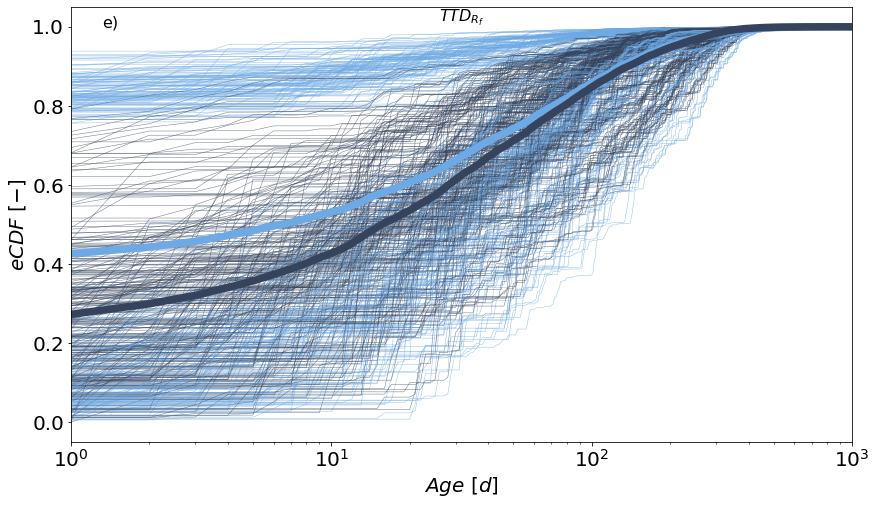

In [ ]:
#lets plot the TTD for S2 and S1 same plot S1 color red and S2 color blue
TTD_Qtot_df= pd.DataFrame(TTD_Qtot)
TTD_Qtot_df = TTD_Qtot_df.iloc[0:1000,1001:Tr_length]
TTD_Qtot_df_cum = TTD_Qtot_df.cumsum()
#Lets do the same for SASt
TTD_Qtot_df_SASt= pd.DataFrame(TTD_Qtot_SASt)
TTD_Qtot_df_SASt = TTD_Qtot_df_SASt.iloc[0:1000,1001:Tr_length]
TTD_Qtot_df_cum_SASt = TTD_Qtot_df_SASt.cumsum()
#PLot SU_RTD  and SGW_RTD by side 
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 8))
#Plot TTD_Qtot
for i in range(1000,Tr_length):
    ax1.plot(np.cumsum(TTD_Qf[0:nt,i]), linewidth=0.5, color="#6DA9E4", label='S2', alpha=0.7)
    ax1.plot(np.cumsum(TTD_Qf_SASt[0:nt,i]), linewidth=0.5, color="#35435c", label='S1', alpha=0.7)
#Add legend
ax1.plot(RF_TTD_Qf.index[0:1000], np.mean(RF_TTD_Qf, axis=1), linewidth=7.5, color="#6DA9E4", label='S1')
ax1.plot(RF_TTD_Qf_SASt.index[0:1000], np.mean(RF_TTD_Qf_SASt, axis=1), linewidth=7.5, color="#35435c", label='S2')
ax1.set_xlabel('$Age\ [d]$')
ax1.set_ylabel('$eCDF\ [-]$')
ax1.set_xlim(1.0, 1000)
#Set log Scale x axes
ax1.set_xscale('log')
ax1.set_title('$TTD_{R_f}$',  y=1.0, pad=-14, fontsize=16)
ax1.text(0.04, 0.98, 'e)', transform=ax1.transAxes,fontsize=16,  va='top')
# ax2.text(0.3, 0.95, 'f)', transform=ax2.transAxes,fontsize=20,  va='top')

In [ ]:
#df_fyw select Where Event =NoRain 
# normilize measure_df prec between 0 and 1
norm_prec = (meas_df['Prec'][wp:nt] - meas_df['Prec'][wp:nt].min()) / (meas_df['Prec'][wp:nt].max() - meas_df['Prec'][wp:nt].min())
# normilize measure_df prec between 0 and 1
norm_Q = (meas_df['Qmmd'][wp:nt] - meas_df['Qmmd'][wp:nt].min()) / (meas_df['Qmmd'][wp:nt].max() - meas_df['Qmmd'][wp:nt].min())
norm_SM  = (meas_df['SWC_Avrg'][wp:nt] - meas_df['SWC_Avrg'][wp:nt].min()) / (meas_df['SWC_Avrg'][wp:nt].max() - meas_df['SWC_Avrg'][wp:nt].min())
#Set index for all to the date
norm_prec.index = meas_df.index[wp:nt]
norm_Q.index = meas_df.index[wp:nt]
norm_SM.index = meas_df.index[wp:nt]
#Lets defien new data  frame for fyw 7 90 and 1 year 
fyw_2 = np.sum(TTD_Qtot[0:2,], axis=0)*100
fyw_7 =  np.sum(TTD_Qtot[0:7,], axis=0)*100
fyw_90 =  np.sum(TTD_Qtot[7:90,], axis=0)*100
fyw_365 =  np.sum(TTD_Qtot[90:365,], axis=0)*100
fyw_old=  1- np.sum(TTD_Qtot[365:nt,], axis=0)*100
fyw_tot =  np.sum(TTD_Qtot[0:90,], axis=0)*100
Fyw_SASt_7 =  np.sum(TTD_Qtot_SASt[0:7,], axis=0)*100
Fyw_SASt_2 =  np.sum(TTD_Qtot_SASt[0:2,], axis=0)*100
Fyw_SASt_90 =  np.sum(TTD_Qtot_SASt[7:90,], axis=0)*100
Fyw_SASt_365 =  np.sum(TTD_Qtot_SASt[90:365,], axis=0)*100
Fyw_SASt_old = 1 - np.sum(TTD_Qtot_SASt[365:nt,], axis=0)*100
Fyw_SASt = np.sum(TTD_Qtot_SASt[0:95,], axis=0)*100
#Eliminate fye_365 >0.1 to NAN

#Append it df_fyw
df_fyw = pd.DataFrame({'Date': meas_df.index[wp:nt], 'Qmmd':  meas_df.Qmmd[wp:nt], 'Qnorm': norm_Q, 'Pmmd': meas_df.Prec[wp:nt], 'Pnorm':norm_prec, 'SM':norm_SM, 'Season': meas_df.Season[wp:nt], 
                       'Season_M':meas_df.Season_M[wp:nt], 'SM_Meas':meas_df.SWC_Avrg[wp:nt],'0_2': fyw_2[wp:nt], '7_90': fyw_90[wp:nt], '0_7': fyw_7[wp:nt], 
                       '90_365': fyw_365[wp:nt],  'Fyw [-]': fyw_tot[wp:nt], 'Old': fyw_old[wp:nt]})
#Set Date as index
#df_fyw = df_fyw.set_index('Date')
df_fyw['case'] = 'S2'
# 
df_fyw_SASt = pd.DataFrame({'Date': meas_df.index[wp:nt],  'Qmmd':  meas_df.Qmmd[wp:nt], 'Qnorm': norm_Q, 'Pmmd': meas_df.Prec[wp:nt], 'Pnorm':norm_prec, 'SM':norm_SM, 'Season': meas_df.Season[wp:nt], 
                            'Season_M':meas_df.Season_M[wp:nt], 'SM_Meas':meas_df.SWC_Avrg[wp:nt], '0_2': Fyw_SASt_2[wp:nt],'7_90': Fyw_SASt_90[wp:nt], '0_7': Fyw_SASt_7[wp:nt],
                            '90_365':Fyw_SASt_365[wp:nt], 'Fyw [-]':Fyw_SASt[wp:nt], 'Old':Fyw_SASt_old[wp:nt]})

df_fyw_SASt['case'] = 'S1'
#Scatter plot S1 vs S2  hue by season
df_fyw_0_2 = pd.DataFrame({'S1':Fyw_SASt_2[wp:nt],  'S2': fyw_2[wp:nt],  'Season': df_fyw_SASt.Season_M})
df_fyw_0_7 = pd.DataFrame({'S1':Fyw_SASt_7[wp:nt],  'S2': fyw_7[wp:nt],  'Season': df_fyw_SASt.Season_M})
df_fyw_7_90 = pd.DataFrame({'S1':Fyw_SASt_90[wp:nt],  'S2': fyw_90[wp:nt],  'Season': df_fyw_SASt.Season_M})
df_fyw_90_365 = pd.DataFrame({'S1':Fyw_SASt_365[wp:nt],  'S2': fyw_365[wp:nt],  'Season': df_fyw_SASt.Season_M})
#Remove values >100



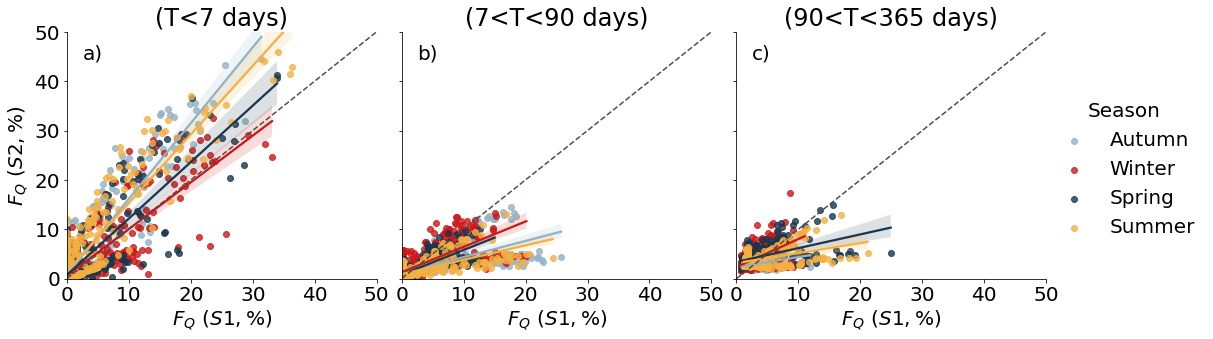

In [ ]:
# Create the individual data frames with the 'Period' column
df_fyw_0_7 = pd.DataFrame({'S1': Fyw_SASt_7[wp:nt], 'S2': fyw_7[wp:nt], 'Season': df_fyw_SASt.Season_M, 'Period': '<7 days'})
df_fyw_7_90 = pd.DataFrame({'S1': Fyw_SASt_90[wp:nt], 'S2': fyw_90[wp:nt], 'Season': df_fyw_SASt.Season_M, 'Period': '7-90 days'})
df_fyw_90_365 = pd.DataFrame({'S1': Fyw_SASt_365[wp:nt], 'S2': fyw_365[wp:nt], 'Season': df_fyw_SASt.Season_M, 'Period': '90-365 days'})

# Concatenate the data frames
df_fyw_tot = pd.concat([df_fyw_0_7, df_fyw_7_90, df_fyw_90_365])
my_pal = { "#f5b041", '#93b2c5', "#193750", "#CD1818"}

# Create the FacetGrid with lmplot
g = sns.lmplot(data=df_fyw_tot, x='S1', y='S2', hue='Season', col='Period', palette=my_pal, height=5, aspect=1)

# Customize the plots
for ax, period in zip(g.axes.flat, df_fyw_tot['Period'].unique()):
    ax.plot([0, 50], [0, 50], ls="--", c=".3")
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_xlabel('$F_{Q}\ (S1, \%)$')
    ax.set_ylabel('$F_{Q}\ (S2, \%)$')
    if period == '<7 days':
        ax.set_title('(T<7 days)')
        ax.text(0.05, 0.95, 'a)', transform=ax.transAxes, fontsize=20, va='top')
    elif period == '7-90 days':
        ax.set_title('(7<T<90 days)')
        ax.text(0.05, 0.95, 'b)', transform=ax.transAxes, fontsize=20, va='top')
    else:
        ax.set_title('(90<T<365 days)')
        ax.text(0.05, 0.95, 'c)', transform=ax.transAxes, fontsize=20, va='top')

# Display the plot
plt.show()

In [ ]:
#Lets get summuriz information mean median and for Fyw and 0_7, 7_90, 90_365 and Old whre values > 0.0
df_summuary = df_fyw[['Fyw [-]','0_2',  '0_7', '7_90', '90_365', 'Old']].describe()
df_summuary_SAST = df_fyw_SASt[['Fyw [-]', '0_2', '0_7', '7_90', '90_365', 'Old']].describe()



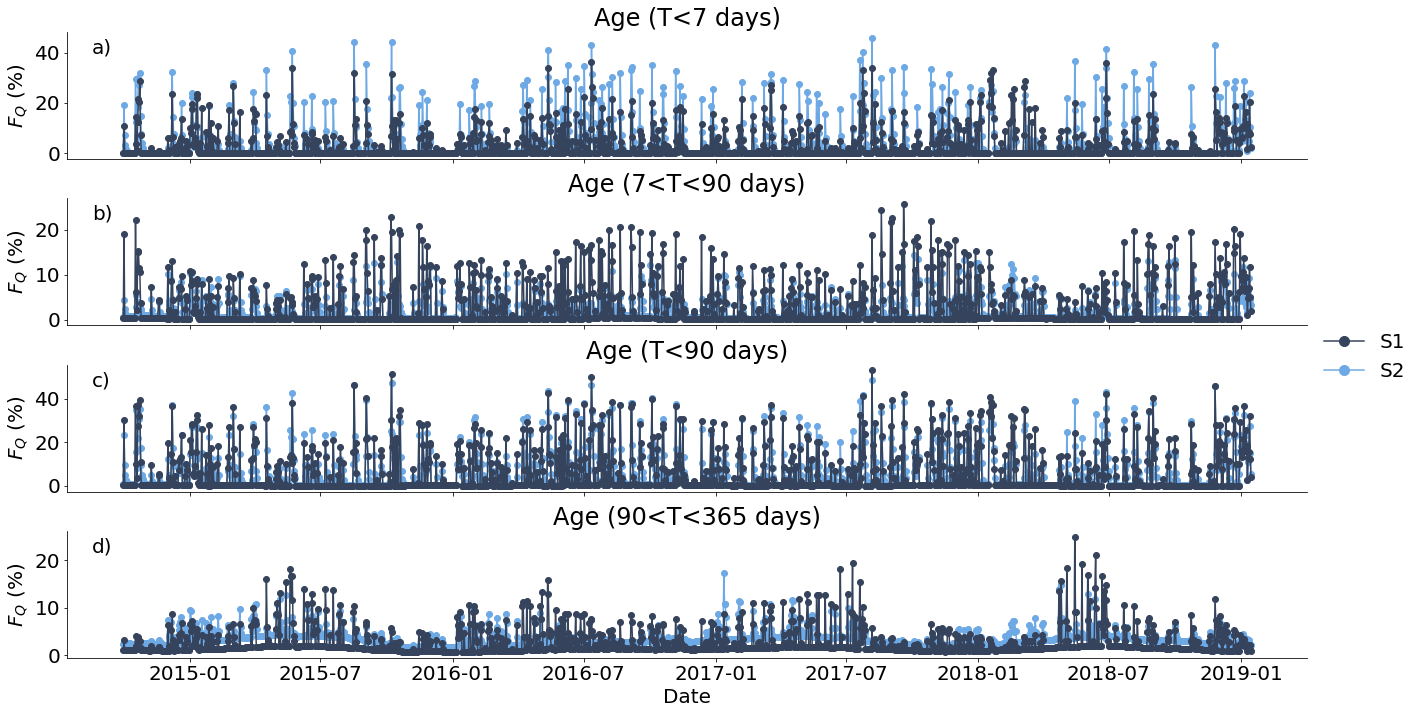

In [26]:
# my_pal = {"S1": "#35435c", "S2": '#f5b041'}
#select df_fyw_tot year 2015
df_fyw_tots = df_fyw_tot.loc['2015-01-01':'2015-12-31']
df_fyw_tots = df_fyw_tot
my_pal = {"S1":"#35435c", "S2": "#6DA9E4"}
#Plot df Value Vars as line color by case facedt by season
g = sns.FacetGrid(df_fyw_tots, hue="case", row = "variable",  palette= my_pal, sharey=False, sharex=True)
g = g.map(plt.plot, 'Date', "Fyw", marker="o")
#Add horizantal line as mean of Fyw[-]  and 0_7 
#Set x axes as df_fyw_tot.index 
g.fig.set_size_inches(28, 10)
#SEt titels as Age 0 to 7 7 to 90 90 to 365 and 0 to 90
#set y label as .set_ylabel('% of Q')
g.set_ylabels('$F_{Q}\ (\%)$', fontsize=20)
#Ad panel neme a, b, c, d 
g.axes[0,0].text(0.02, 0.95, 'a)', transform=g.axes[0,0].transAxes,fontsize=20,  va='top')
g.axes[1,0].text(0.02, 0.95, 'b)', transform=g.axes[1,0].transAxes,fontsize=20,  va='top')
g.axes[2,0].text(0.02, 0.95, 'c)', transform=g.axes[2,0].transAxes,fontsize=20,  va='top')
g.axes[3,0].text(0.02, 0.95, 'd)', transform=g.axes[3,0].transAxes,fontsize=20,  va='top')
#Set axs titles as F(T<7) and F(T<90)
g.axes[0,0].set_title('Age (T<7 days)')
g.axes[1,0].set_title('Age (7<T<90 days)')
g.axes[2,0].set_title('Age (T<90 days)')
g.axes[3,0].set_title('Age (90<T<365 days)')

#Renamse lagend as Scenario 1 and Scenario 2
# g.add_legend(title='Scenario', labels=['Scenario 1', 'Scenario 2'])

# Create dotted line objects with a dot in the center for the legend
S1_dotted_line = Line2D([0], [1], color="#35435c", linestyle='-', marker='o', markersize=10, label='S1')
S2_dotted_line = Line2D([0], [1], color="#6DA9E4", linestyle='-', marker='o', markersize=10, label='S2')

# Assuming 'g' is your plot object, add the legend
g.add_legend(handles=[S1_dotted_line, S2_dotted_line], loc='center right', title=False, fontsize=20)

# Display the plot
plt.show()


In [27]:
#Concat df_fyw and df_fyw_SASt
df_fyw_Con = pd.concat([df_fyw_SASt, df_fyw])
df_fyw_Con=df_fyw_Con.dropna()
# df_fyw_Con=df_fyw_Con.sort_values(by='Season', ascending=False)
offsets_dict = {}
# Custom function to annotate the plot with color in the top right corner, with dynamic vertical positioning
def annotate_plot(x, y, color,  **kws):
    global offsets_dict
    # r, p = pearsonr(x, y)
    #Get sperman rank correlation
    rho, p = spearmanr(x, y)
    ax = plt.gca()  # Get the current Axes instance
    # Get the current offset for this Axes instance, or initialize it
    offset = offsets_dict.get(ax, 0.95)
    new_offset = offset - 0.15  # Adjust the vertical position for the next annotation
    
    # Update the offset in the dictionary
    offsets_dict[ax] = new_offset

    # Position for the annotation in the top right corner with dynamic offset
    if p > 0.05:
       ax.text(0.95, offset, f'r={rho:.2f}\np>0.05', color=color, fontsize=20, ha='right', va='top', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    else:
      ax.text(0.95, offset, f'r={rho:.2f}\np<0.05', color=color, fontsize=20, ha='right', va='top', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    
    #Change P value to scientific notation as p<0.05
    # ax.text(0.95, offset, f'r={r:.2f}\np<0.01', color=color, fontsize=12, ha='right', va='top', transform=ax.transAxes)
    #ax.text(0.95, offset, f'r={r:.2f}\np<0.01', color=color, fontsize=15, ha='right', va='top', transform=ax.transAxes)

In [28]:
#melt Dfyw long by Condition columns Qmm, Pmmd, SM
df_fyw_melt = pd.melt(df_fyw_Con, id_vars=['Fyw [-]','case','0_7', '90_365'], value_vars=['Qmmd', 'Pmmd', 'SM_Meas'], value_name='Condition',ignore_index=False)

Text(0.02, 0.95, 'c)')

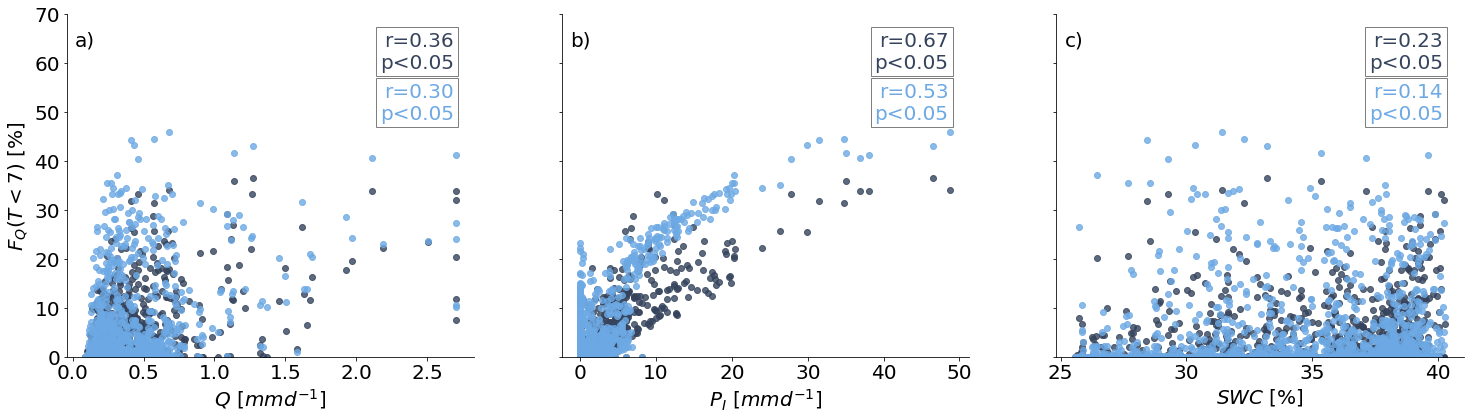

In [ ]:
#Facet by Condition scatter plot '0_7' vs 'Condition' by case
g = sns.FacetGrid(df_fyw_melt, col="variable",  hue ='case', palette= my_pal, sharey=True, sharex= False )
g = g.map(sns.regplot, 'Condition', "0_7", marker="o",   fit_reg=False, order=1)
g.map(annotate_plot, 'Condition', '0_7')
g.set(ylim=(0, 70))
g.fig.set_size_inches(23, 10)
g.axes[0,0].set_xlabel('$Q\ [mmd^{-1}]$')
g.axes[0,1].set_xlabel('$P_I\ [mmd^{-1}]$')
g.axes[0,2].set_xlabel("$SWC\ [\%]$") 
#Set y label as .set_ylabel('% of Q (T<90)')
g.set_ylabels('$F_{Q}(T<7)\ [\%]$')
g.set_titles("")
g.axes[0,0].text(0.02, 0.95, 'a)', transform=g.axes[0,0].transAxes,fontsize=20,  va='top')
g.axes[0,1].text(0.02, 0.95, 'b)', transform=g.axes[0,1].transAxes,fontsize=20,  va='top')
g.axes[0,2].text(0.02, 0.95, 'c)', transform=g.axes[0,2].transAxes,fontsize=20,  va='top')
